In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


project_root = Path().resolve().parent  

# pastas de dados
dados_dir = project_root / "project" / "data" / "raw"

arquivos_poluicao = [
    dados_dir / "Poluicao" / "2019-campinas.csv",
    dados_dir / "Poluicao" / "2020-campinas.csv",
    dados_dir / "Poluicao" / "2021-campinas.csv",
    dados_dir / "Poluicao" / "2022-campinas.csv",
    dados_dir / "Poluicao" / "2023-campinas.csv",
]

arquivos_vento = [
    dados_dir / "Vento" / "v2019.csv",
    dados_dir / "Vento" / "v2020.csv",
    dados_dir / "Vento" / "v2021.csv",
    dados_dir / "Vento" / "v2022.csv",
    dados_dir / "Vento" / "v2023.csv",
]

lista_dfs_combinados = []

# Loop para processar os pares de arquivos (poluição + vento)
for arq_pol, arq_vento in zip(arquivos_poluicao, arquivos_vento):

    # --- Processamento do DataFrame de Poluição ---
    df_pol = pd.read_csv(arq_pol, skiprows=7, sep=';', encoding='latin-1', header=None, dtype=str)
    df_pol.rename(columns={0: 'Data', 1: 'Hora', 2: 'pm25', 3: 'temp', 4: 'umidade'}, inplace=True)
    df_pol = df_pol[['Data', 'Hora', 'pm25', 'temp', 'umidade']]
    df_pol.dropna(subset=['Data', 'Hora'], inplace=True)
    
    mask_hora_24_pol = df_pol['Hora'].str.startswith('24', na=False)
    if mask_hora_24_pol.any():
        datas_corrigidas = pd.to_datetime(df_pol.loc[mask_hora_24_pol, 'Data'], format='%d/%m/%Y') + pd.Timedelta(days=1)
        df_pol.loc[mask_hora_24_pol, 'Data'] = datas_corrigidas.dt.strftime('%d/%m/%Y')
        df_pol.loc[mask_hora_24_pol, 'Hora'] = '00:00'
        
    df_pol['timestamp'] = pd.to_datetime(df_pol['Data'] + ' ' + df_pol['Hora'], format='%d/%m/%Y %H:%M', errors='coerce')
    df_pol.dropna(subset=['timestamp'], inplace=True)
    df_pol.set_index('timestamp', inplace=True)
    df_pol.drop(['Data', 'Hora'], axis=1, inplace=True)
    
    # --- Processamento do DataFrame de Vento ---
    df_vento = pd.read_csv(arq_vento, skiprows=7, sep=';', encoding='latin-1', header=None, dtype=str)
    df_vento.rename(columns={0: 'Data', 1: 'Hora', 2: 'vento_dir', 3: 'vento_vel'}, inplace=True)
    df_vento = df_vento[['Data', 'Hora', 'vento_dir', 'vento_vel']]
    df_vento.dropna(subset=['Data', 'Hora'], inplace=True)

    mask_hora_24_vento = df_vento['Hora'].str.startswith('24', na=False)
    if mask_hora_24_vento.any():
        datas_corrigidas = pd.to_datetime(df_vento.loc[mask_hora_24_vento, 'Data'], format='%d/%m/%Y') + pd.Timedelta(days=1)
        df_vento.loc[mask_hora_24_vento, 'Data'] = datas_corrigidas.dt.strftime('%d/%m/%Y')
        df_vento.loc[mask_hora_24_vento, 'Hora'] = '00:00'
        
    df_vento['timestamp'] = pd.to_datetime(df_vento['Data'] + ' ' + df_vento['Hora'], format='%d/%m/%Y %H:%M', errors='coerce')
    df_vento.dropna(subset=['timestamp'], inplace=True)
    df_vento.set_index('timestamp', inplace=True)
    df_vento.drop(['Data', 'Hora'], axis=1, inplace=True)

    # --- União (Join) dos DataFrames ---
    df_combinado = df_pol.join(df_vento, how='outer')
    lista_dfs_combinados.append(df_combinado)

# Concatena a lista de DataFrames já combinados anualmente
df = pd.concat(lista_dfs_combinados)

colunas_numericas = ['pm25', 'temp', 'umidade', 'vento_dir', 'vento_vel']
for col in colunas_numericas:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

df.sort_index(inplace=True)
df.index = df.index - pd.Timedelta(hours=1)
df = df.asfreq('H')

# Exibição dos resultados
display(df.head())
print("\nVerificando valores nulos após a união:")
print(df.isnull().sum())


,pm25,temp,umidade,vento_dir,vento_vel
timestamp,,,,,
2019-01-01 00:00:00,26.0,23.5,70.0,137.0,4.6
2019-01-01 01:00:00,31.0,22.9,73.0,128.0,3.5
2019-01-01 02:00:00,18.0,22.6,75.0,174.0,1.5
2019-01-01 03:00:00,26.0,22.0,79.0,155.0,1.8
2019-01-01 04:00:00,29.0,21.7,81.0,163.0,1.8



Verificando valores nulos após a união:
pm25         6819
temp         3492
umidade      3489
vento_dir    3524
vento_vel    3524
dtype: int64


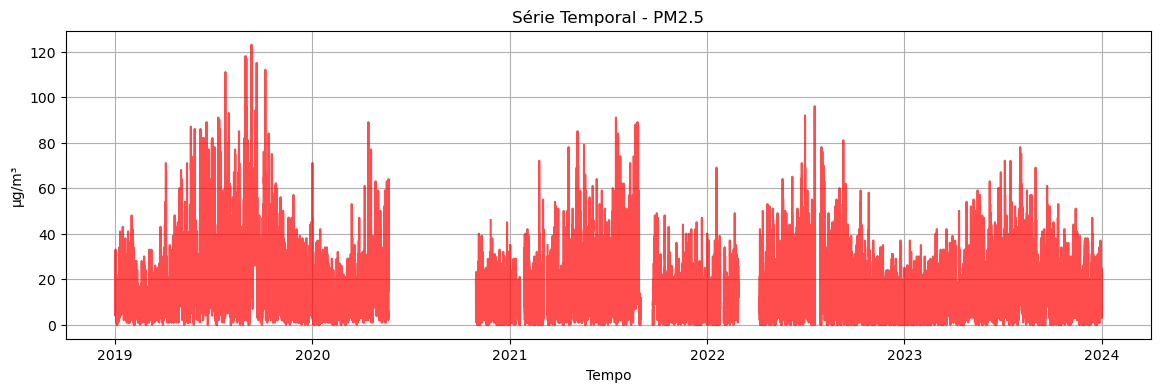

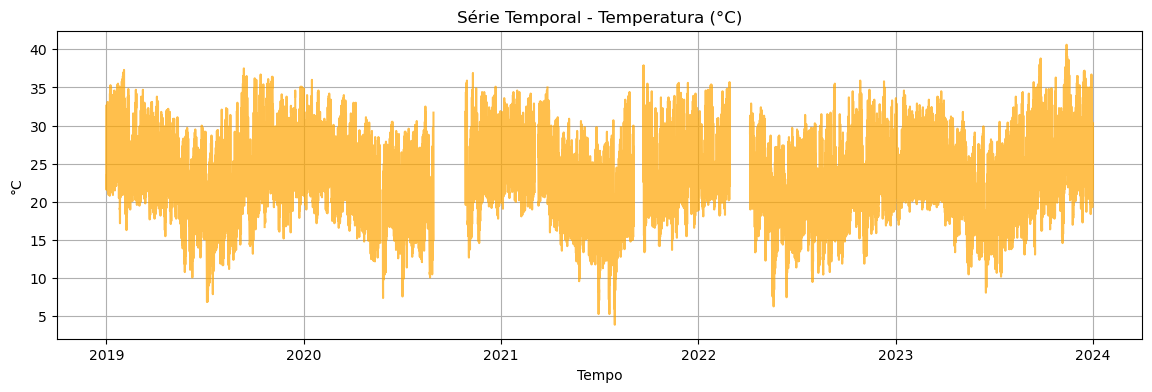

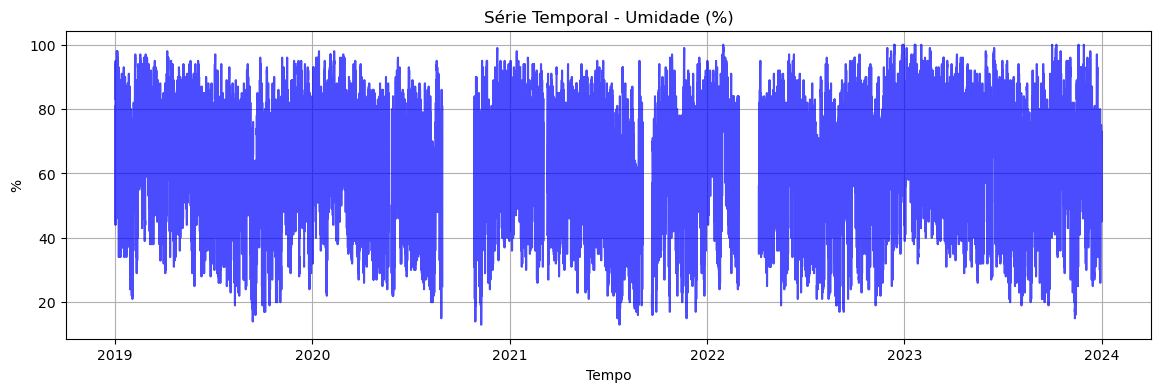

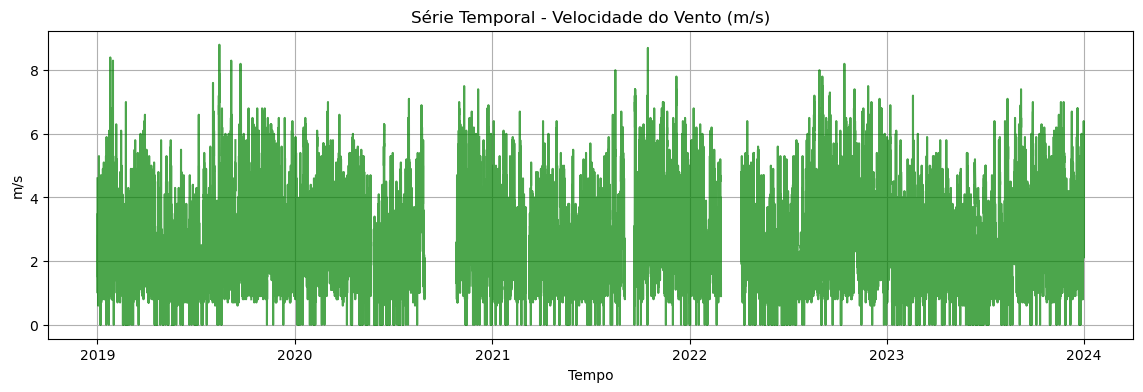

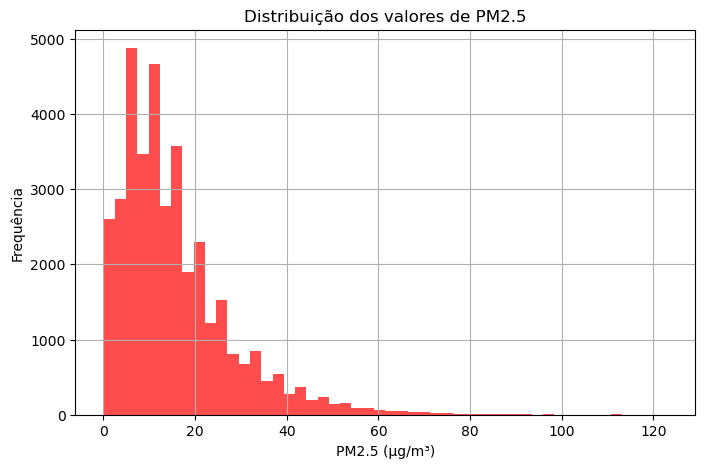

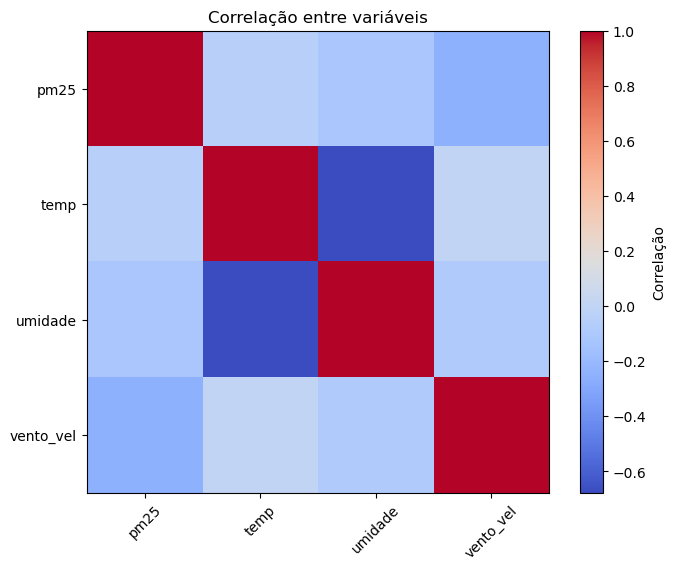

In [3]:
# --- Série temporal: PM2.5 ---
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['pm25'], color="red", alpha=0.7)
plt.title("Série Temporal - PM2.5")
plt.xlabel("Tempo")
plt.ylabel("µg/m³")
plt.grid(True)
plt.show()

# --- Série temporal: Temperatura ---
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['temp'], color="orange", alpha=0.7)
plt.title("Série Temporal - Temperatura (°C)")
plt.xlabel("Tempo")
plt.ylabel("°C")
plt.grid(True)
plt.show()

# --- Série temporal: Umidade ---
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['umidade'], color="blue", alpha=0.7)
plt.title("Série Temporal - Umidade (%)")
plt.xlabel("Tempo")
plt.ylabel("%")
plt.grid(True)
plt.show()

# --- Série temporal: Velocidade do Vento ---
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['vento_vel'], color="green", alpha=0.7)
plt.title("Série Temporal - Velocidade do Vento (m/s)")
plt.xlabel("Tempo")
plt.ylabel("m/s")
plt.grid(True)
plt.show()

# --- Histograma da distribuição de PM2.5 ---
plt.figure(figsize=(8, 5))
plt.hist(df['pm25'].dropna(), bins=50, color='red', alpha=0.7)
plt.title("Distribuição dos valores de PM2.5")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

# --- Matriz de correlação ---
plt.figure(figsize=(8, 6))
corr = df[['pm25','temp','umidade','vento_vel']].corr()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Correlação")
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlação entre variáveis")
plt.show()
